# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although
#results are returned in arbitrary order

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


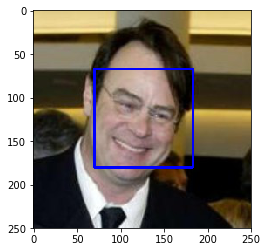

In [2]:
import cv2                #OpenCV:Is a software library that is useful for computer vision and machine learning 
                          # this library can provide pre-trained face detectors 
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector #class to detect objects in a video stream
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml') 

# load color (BGR) image #cv2.imread() is to read an image.
img = cv2.imread(human_files[0]) 
#function cv2.cvColor(input_image, flag) is used for color conversion
#flag determines the type of the conversion 
# convert BGR image to grayscale 

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
#The detectMultiScale function executes the classifier stored in face_cascade and takes the grayscale image as a parameter.
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    #cv2.rectangle(img, point1, point2, color[, thickness[, lineType[, shift]]]) → None
    
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

Answer: The percentage of the first 100 images in human_files have a detected human face is : 98% 
The percentage of the first 100 images in dog_files have a detected human face is: 17%

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


#vectorization 
face_vectorization = np.vectorize(face_detector)
#recognition of human and dog faces using the vectorize face detector
human_faces = face_vectorization(human_files_short)
dog_faces = face_vectorization(dog_files_short)

#printing the result 
print('percentage of human face detection from human dataset file is {:.2f}%'.format((sum(human_faces)/len(human_faces))*100))
print('percentage of human face detection from dog dataset file is {:.2f}%'.format((sum(dog_faces)/len(dog_faces))*100))



percentage of human face detection from human dataset file is 98.00%
percentage of human face detection from dog dataset file is 17.00%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
#optional 
#another methos that can be used from opencv library is lbp cascade classifier 
#first load the lbp cascade classifier 
lbp_cascade_classifier  = cv2.CascadeClassifier('lbpcascade/xmltest.xml') 
#definition for detecting the face 
def lbp_face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = lbp_cascade_classifier.detectMultiScale(gray)
    return len(faces) > 0

#vectorization 
face_vectorization = np.vectorize(lbp_face_detector)
#recognition of human and dog faces using the vectorize face detector
human_faces = face_vectorization(human_files_short)
dog_faces = face_vectorization(dog_files_short)

#printing the result 
print('percentage of human face detection from human dataset file is {:.2f}%'.format((sum(human_faces)/len(human_faces))*100))
print('percentage of human face detection from dog dataset file is {:.2f}%'.format((sum(dog_faces)/len(dog_faces))*100))


percentage of human face detection from human dataset file is 82.00%
percentage of human face detection from dog dataset file is 6.00%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image #to read the image
import torchvision.transforms as transforms
#from torch.autograd import Variable 



train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Cuda is not available. Training on CPU..')
else:
    print('Cuda is available. Training on GPU..')



        
VGG16.eval() #will turn off drop out and will give the highest performance out of network , when prediction is needed , we should use this -
print(VGG16)


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path) #open the image 
    #convert to pytorch transform , 
    #introducing the randomness in the input data by data augmentation 
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    img = data_transform(img)[:3,:,:].unsqueeze(0)
    #img = img[].unsqueeze_(0) #add a dimension to a tensor 
    
    if use_cuda:
        img = img.cuda()
        
    output = VGG16(img)
    #convert output probabilities to predicted class 
    _, pred = torch.max(output, 1)
    #compare prediction to true label #squeeze for Remove single-dimensional entries from the shape of an array.
    correct = np.squeeze(pred.numpy()) if not train_on_gpu else np.squeeze(pred.cpu().numpy())
    
    
    return correct 

Cuda is available. Training on GPU..
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path


def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    if(index > 151 and index <= 268):
        return True
    else:
        return False 
#check if it predicts right 
print(dog_detector(human_files[0]))
print(dog_detector(dog_files[0]))

False
True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

Answer:
The percentage of the first 100 images in human_files have a detected human face is : 98% 
The percentage of the first 100 images in dog_files have a detected human face is: 17%


In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

dog_vectorized = np.vectorize(dog_detector)
human_faces = dog_vectorized(human_files_short)
dog_faces = dog_vectorized(dog_files_short)


print('percentage of dog face detection from human dataset file is {:.2f}%'.format((sum(human_faces)/len(human_faces))*100))
print('percentage of dog face detection from dog dataset file is {:.2f}%'.format((sum(dog_faces)/len(dog_faces))*100))


percentage of dog face detection from human dataset file is 2.00%
percentage of dog face detection from dog dataset file is 98.00%


In [10]:
#another suggested way 
total_humans = len(human_files_short)
total_dogs = len(dog_files_short)

notdetectDog_in_human = 0
for i in range(0, total_humans-1):
    if dog_detector(human_files_short[i]) == False:
        notdetectDog_in_human += 1
        
detectDog_in_dog = 0
for i in range(0, total_dogs-1):
    if dog_detector(dog_files_short[i]) == True:
        detectDog_in_dog +=1
        
print('percentage of dog face detection from human dataset file is {:.2f}%'.format(100-((notdetectDog_in_human/total_humans)*100)))
print('percentage of dog face detection from dog dataset file is {:.2f}%'.format((detectDog_in_dog/total_dogs)*100))
        


percentage of dog face detection from human dataset file is 3.00%
percentage of dog face detection from dog dataset file is 96.00%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [23]:
import os #provides a portable way of using operating system dependent functionality
from torchvision import datasets

import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_workers = 0 #number of subprocesses to use for data loading 
batch_size = 20
data_dir = '/data/dog_images' #general directory

#define a dictionary of on the way of transformation on our data including train, validation and test set 

data_transforms ={
    'train': transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]), 
    'valid': transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(),  
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        
    ])
}

#the path to each dataset 
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

#defining our dataset

image_datasets = {
    'train': datasets.ImageFolder(root = train_dir, transform = data_transforms['train']), 
    'valid': datasets.ImageFolder(root = valid_dir, transform = data_transforms['valid']), 
    'test' : datasets.ImageFolder(root = test_dir, transform = data_transforms['test'])
}

#loading the images
loaders_scratch = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = batch_size, shuffle = True), 
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size = batch_size), 
    'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size = batch_size)
    
}



**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


Answer:
for image transformation, I used transforms as Resize, RandomResizeCrop, CenterCrop and Totensor. 
Resizing the image is done with transforms.Resize and this will give us the images with fixed size of 224. 
for the train_dataset, I used data augmentation and introduce randomness (RandomResize, RandomRotation and RandomHorizontalFlip) in the input data itself. By this, I can avoid from overfitting , therfore i would have a better performance on my training data and consequently better result in validation and test set. But in the valid and test set, I just used CenterCrop. Finally, at the end I pass them into tensor. 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [24]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch.nn as nn
import torch.nn.functional as F


num_of_classes = 133

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        #define 3 convolutional layer 
        self.conv1 = nn.Conv2d(3, 32, 3, stride =2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride =2, padding =1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding =1)
        
        #maxpooling layer 
        self.pool = nn.MaxPool2d(2,2) #with the kernel size and stride of 2
        
        #fully connected layers with two layers
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_of_classes)
        
        #dropout function 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        #standardize the output value of the filters 
        x = F.relu(self.conv1(x))
        #reducing the dimension of XY / decrease the spatial dimension of the output #less patameter, decrease the chance of overfitting 
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        #feature representation level or feature content which encodes only the content of image 
        #flatten the data 
        x = x.view(-1, 7*7*128)
   
        #dropout , then probability that we drop out a unit, so weights should share between other nodes
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #output 
        x = self.fc2(x)
       
        
        return x
    
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

Answer: I define a total 3 convolutional layers , in the first 2 layers, I have a convolutional kernels with the size of 3 and stride of 2 which means in each step, we have a downsize of 2. after each step, I used a maxpooling function with the stride of 2 (input image in downsized by 2) , the purpose of this step is discarding the spatial information and gets a deeper network , consequesntly by having a deeper network, more complex pattern and features can be extraxted. 
In the last convolutional layer , I did not reduce the image input by chooosing stride=1 and kernel size of 3. 
in the next step, our output image with the depth of 128 is flatten to a vector and pass through the fully connected layer.
(in convolutional layer , we will get information about the content but we can not predict specifically, therefore we need a fully-connected layer classification)
Dropout is used in oder to avoid overfitting 
in the last step (2nd fc layer), we can do prediction , in this case means predicting the classes of the breeds. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [25]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [26]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            
            optimizer.zero_grad() # clear all the gradients of the parameters of previous calculation, so initialize the weights to zero
            output = model(data) #forward pass
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step() #update the parameters by performing a sigle optimization step 
            
                    
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            train_loss += loss.item() * data.size(0) #accumulating the train_loss over the batch
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            #forward pass
            output = model(data)
            loss = criterion(output, target)
            
            ## update the average validation loss
            valid_loss += loss.item()* data.size(0)
        # train and valid loss value that averaged over the batch 
        train_loss = train_loss / len(loaders['train'].dataset)
        valid_loss = valid_loss / len(loaders['valid'].dataset)
        

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if  valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}). Save the model..'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
            
    # return trained model
    return model


# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
#model_scratch = Net()
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
#model_scratch.eval()
#model_scratch.cuda()
print(model_scratch)

Epoch: 1 	Training Loss: 4.868113 	Validation Loss: 4.795503
validation loss decreased (inf --> 4.795503). Save the model..
Epoch: 2 	Training Loss: 4.771510 	Validation Loss: 4.575493
validation loss decreased (4.795503 --> 4.575493). Save the model..
Epoch: 3 	Training Loss: 4.636668 	Validation Loss: 4.525948
validation loss decreased (4.575493 --> 4.525948). Save the model..
Epoch: 4 	Training Loss: 4.567685 	Validation Loss: 4.440019
validation loss decreased (4.525948 --> 4.440019). Save the model..
Epoch: 5 	Training Loss: 4.528087 	Validation Loss: 4.319540
validation loss decreased (4.440019 --> 4.319540). Save the model..
Epoch: 6 	Training Loss: 4.470563 	Validation Loss: 4.295921
validation loss decreased (4.319540 --> 4.295921). Save the model..
Epoch: 7 	Training Loss: 4.407156 	Validation Loss: 4.164052
validation loss decreased (4.295921 --> 4.164052). Save the model..
Epoch: 8 	Training Loss: 4.361845 	Validation Loss: 4.111871
validation loss decreased (4.164052 --> 4

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [27]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.698452


Test Accuracy: 13% (116/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [28]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [29]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.resnet50(pretrained=True) #load a pretrained model from pytorch



In [30]:
#freeze the training for all 'features' layer in resnet50, so the weights will not be considered in the gradient
for param in model_transfer.parameters():
    param.requires_grad = False

#changing the last layer and tune the classification portion with a new fully_connected layer
model_transfer.fc = nn.Linear(2048, 133, bias = True)
fc_parameters = model_transfer.fc.parameters()

#we want to update the weight of last fc layer so we should not freeze that
for param in fc_parameters:
    param.requires_grad = True
    
model_transfer

if use_cuda:
    model_transfer = model_transfer.cuda()
    print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

Answer:
I used the resnet50 architecture (which has very low top_1 error. Another reason is since ResNet has 3 channels as input and my dog breed images are RGB images, thus this model would be appropriate. The purpose of pretrained model is that we already trained it and the features are extracted. therefore,I freezed the features and i do not want to update the weights. The only thing that should be changed and updated is last layer which is a fc layer (classifier) which we need to train it again.




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [31]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr= 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [32]:
# train the model
n_epochs = 20 

#use the function that we defined in previous section 
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy 
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
#model_transfer.eval()
#model_transfer.cuda()
#print(model_transfer)

Epoch: 1 	Training Loss: 4.841209 	Validation Loss: 4.687179
validation loss decreased (inf --> 4.687179). Save the model..
Epoch: 2 	Training Loss: 4.650651 	Validation Loss: 4.466835
validation loss decreased (4.687179 --> 4.466835). Save the model..
Epoch: 3 	Training Loss: 4.490608 	Validation Loss: 4.267052
validation loss decreased (4.466835 --> 4.267052). Save the model..
Epoch: 4 	Training Loss: 4.338185 	Validation Loss: 4.070958
validation loss decreased (4.267052 --> 4.070958). Save the model..
Epoch: 5 	Training Loss: 4.187558 	Validation Loss: 3.875407
validation loss decreased (4.070958 --> 3.875407). Save the model..
Epoch: 6 	Training Loss: 4.040771 	Validation Loss: 3.693655
validation loss decreased (3.875407 --> 3.693655). Save the model..
Epoch: 7 	Training Loss: 3.903890 	Validation Loss: 3.502036
validation loss decreased (3.693655 --> 3.502036). Save the model..
Epoch: 8 	Training Loss: 3.781561 	Validation Loss: 3.327818
validation loss decreased (3.502036 --> 3

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [33]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.931381


Test Accuracy: 70% (591/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]

class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]


In [35]:
loaders_transfer['train'].dataset.classes[:10]

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog']

In [36]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [37]:
def predict_breed_transfer(img_path):
    
    # load the image and return the predicted breed
    #open the image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    #prediction should be in the same format
    prediction = transforms.Compose([transforms.Resize(size = (224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    img = prediction(img)[:3,:,:].unsqueeze(0)  # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    img = img.cuda()
    model_transfer.eval()
    index = torch.argmax(model_transfer(img))
    
    return class_names[index]


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [38]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    #open the image and plot it 
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path) is True:
        print(img_path)
        prediction = predict_breed_transfer(img_path)
        print('dog is detected and the predicted breed is {}'.format(prediction))
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(img_path)        
        print('human is detected and if you were a dog, you look like a {}'.format(prediction))
    else:
        print('this image is neither human nor dog')

    

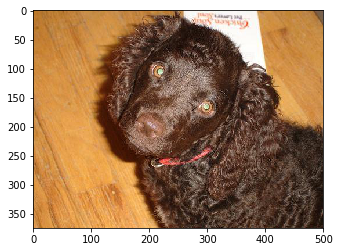

./images/American_water_spaniel_00648.jpg
dog is detected and the predicted breed is Curly-coated retriever


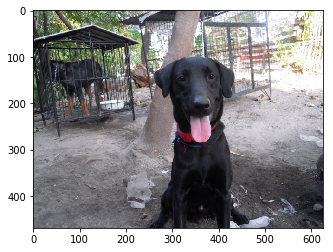

./images/Labrador_retriever_06449.jpg
dog is detected and the predicted breed is Flat-coated retriever


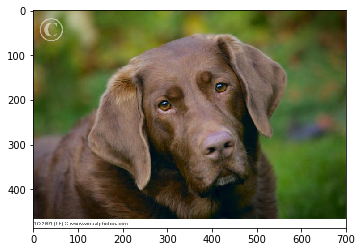

./images/Labrador_retriever_06455.jpg
dog is detected and the predicted breed is Chesapeake bay retriever


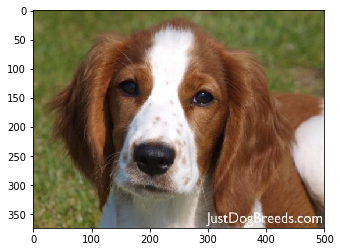

./images/Welsh_springer_spaniel_08203.jpg
dog is detected and the predicted breed is Welsh springer spaniel


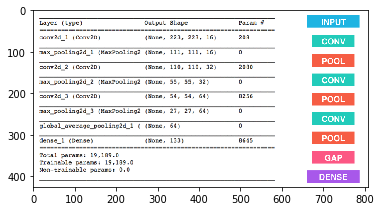

this image is neither human nor dog


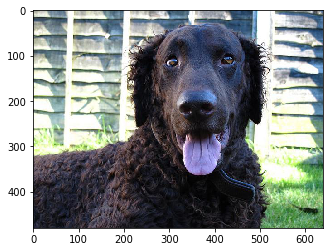

./images/Curly-coated_retriever_03896.jpg
dog is detected and the predicted breed is Curly-coated retriever


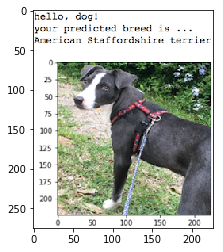

./images/sample_dog_output.png
dog is detected and the predicted breed is Italian greyhound


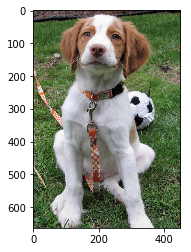

./images/Brittany_02625.jpg
dog is detected and the predicted breed is Brittany


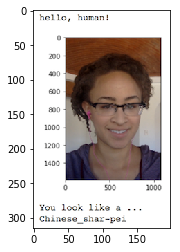

human is detected and if you were a dog, you look like a Dogue de bordeaux


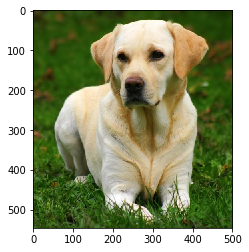

./images/Labrador_retriever_06457.jpg
dog is detected and the predicted breed is Labrador retriever


In [39]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

Answer: 
1. First, we can increase the size of our datasets , so the more we train the model, the more it can learn
2. we can add more image augmentation ; by doing this first we can avoid from overfitting and second by using another augmentation like moving to right or left(transcriptional) , we can expect a better performance on our test
3. Hyper-parameter tuning:several factors can be useful here including initializing the weight, using a better learning learn or even different batch-sizes..

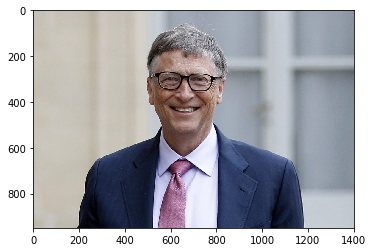

human is detected and if you were a dog, you look like a Brussels griffon


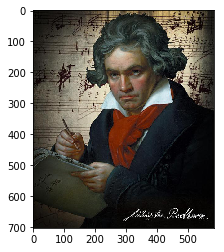

human is detected and if you were a dog, you look like a Havanese


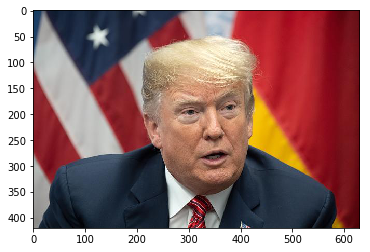

human is detected and if you were a dog, you look like a Norfolk terrier


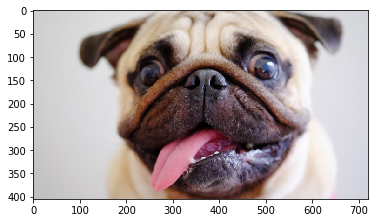

./test_images/dog_1.jpg
dog is detected and the predicted breed is Bulldog


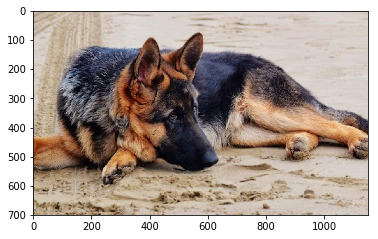

./test_images/dog_2.jpg
dog is detected and the predicted breed is German shepherd dog


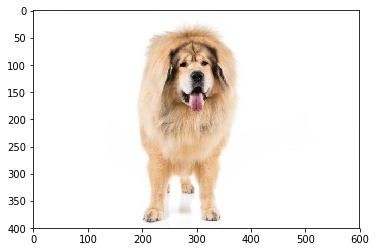

./test_images/dog_3.jpg
dog is detected and the predicted breed is Chow chow


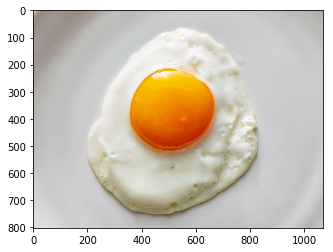

this image is neither human nor dog


In [40]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
#create a folder for my test images and classified them 
test_human_files = ['./test_images/human_1.jpg', './test_images/human_2.jpg', './test_images/human_3.jpg' ]
test_dog_files = ['./test_images/dog_1.jpg', './test_images/dog_2.jpg', './test_images/dog_3.jpg']
test_none_files = ['./test_images/none_1.jpg']
# np.hstack Stack arrays in sequence horizontally (column wise).
for file in np.hstack((test_human_files, test_dog_files, test_none_files)):
    run_app(file)

    